In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc

from sklearn.utils import resample

import warnings
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('semua_terpakai.csv', encoding = 'utf-16')
df['POS']= np.where(df['senti'] == 'positif', '1', '0')
df['NET']= np.where(df['senti'] == 'netral', '1', '0')
df['NEG']= np.where(df['senti'] == 'negatif', '1', '0')
df['TER']= np.where(df['level_bahasa'] == 'teratur', '1', '0')
df['SED']= np.where(df['level_bahasa'] == 'sedang', '1', '0')
df['TTE']= np.where(df['level_bahasa'] == 'tidak teratur', '1', '0')
df['IND']= np.where(df['jenis_bahasa'] == 'Indonesia_murni', '1', '0')
df['CBI']= np.where(df['jenis_bahasa'] == 'campur_bahasa_Inggris', '1', '0')
df['CBD']= np.where(df['jenis_bahasa'] == 'campur_bahasa_daerah', '1', '0')
df['ENG']= np.where(df['jenis_bahasa'] == 'Inggris_murni', '1', '0')

#y = df.balance
#X = df.drop('balance', axis=1)
df_majority = df[df.POS== '0' ]

df_minority = df[df.POS== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=588,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.NEG== '0' ]

df_minority_2 = df_upsampled[df_upsampled.NEG== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=588,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df_upsampled_2.senti.value_counts()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


negatif    588
positif    588
netral     588
Name: senti, dtype: int64

In [2]:
df_upsampled_2.Comment=df_upsampled_2.Comment.astype(str)
df_upsampled_2

,Comment,sentiment,senti,jenis_bahasa,level_bahasa,POS,NET,NEG,TER,SED,TTE,IND,CBI,CBD,ENG
1,we need thanos to bring balance to the our universe,0,netral,Inggris_murni,teratur,0,1,0,1,0,0,0,0,0,1
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
6,menang d pengadilan dunia tapi tunggu pengadilan akhirat,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
13,bismillah ya allah semoga engkau hilang kan virus didunia ini musnah kan ya allah,0,netral,Indonesia_murni,teratur,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,ammmmmbyaaaaarrrr booooooz,-0.1,negatif,campur_bahasa_daerah,tidak teratur,0,0,1,0,0,1,0,0,1,0
22,ridwan kamil mesra banget sama summarecon di bandung juga dia yg ngasih ijin pembangunan summarecon gedebage pdhl itu zona hijau dan resapan,-0.13,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0
152,akhirnya ikut rangga sasana sunda empire,-0.1,negatif,Indonesia_murni,teratur,0,0,1,1,0,0,1,0,0,0
1104,makin kesini makin kelihatan covid cuma jadi alat supaya bisa ngatur hidup orang orang menuju tata dunia baru bahkan sekarang istilah the new normal dipakai di semua media massa seolah tidak bisa dihindari,-0.143181818,negatif,campur_bahasa_Inggris,teratur,0,0,1,1,0,0,0,1,0,0


In [3]:
df_=df_upsampled_2.drop(['sentiment','senti','jenis_bahasa','level_bahasa','TER','SED','TTE','IND','CBI','CBD','ENG'], axis =1)
df_

,Comment,POS,NET,NEG
1,we need thanos to bring balance to the our universe,0,1,0
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,1,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,0,1,0
6,menang d pengadilan dunia tapi tunggu pengadilan akhirat,0,1,0
13,bismillah ya allah semoga engkau hilang kan virus didunia ini musnah kan ya allah,0,1,0
...,...,...,...,...
32,ammmmmbyaaaaarrrr booooooz,0,0,1
22,ridwan kamil mesra banget sama summarecon di bandung juga dia yg ngasih ijin pembangunan summarecon gedebage pdhl itu zona hijau dan resapan,0,0,1
152,akhirnya ikut rangga sasana sunda empire,0,0,1
1104,makin kesini makin kelihatan covid cuma jadi alat supaya bisa ngatur hidup orang orang menuju tata dunia baru bahkan sekarang istilah the new normal dipakai di semua media massa seolah tidak bisa dihindari,0,0,1


In [4]:
df_['POS']=df_['POS'].astype(int)
df_['NET']=df_['NET'].astype(int)
df_['NEG']=df_['NEG'].astype(int)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_, test_size=0.2, random_state = 23)
train

,Comment,POS,NET,NEG
964,kalau kurva udah turun sih gak ada masalah bahas new normal,0,0,1
646,mikirin ekonomi negara masyarakat dijadikan tumbal,0,0,1
1391,implikasi new normal adalah new modar,0,0,1
234,news anchor ny yg tau,0,1,0
177,program dan program kebijakan dan kebijakan padahal yg satunya belum ada yg selesai astagfirullah ya allah,0,0,1
...,...,...,...,...
796,udah cape pak turun aja dari jabatan pusing denger nya,0,0,1
286,tni polri sudah bagus sebagai keamanan new normal semangat dunia,1,0,0
35,survive imun kuat dia yg bertahan this is battleground,1,0,0
1046,seharusnya keadaan ekonomi tidak seperti sekarang ini kalau pemerintah waktu itu cepat bertindak cukup hari atau minggu jadi nggak perlu new an wong kalau masyarakat sekarang sdh mencari kehidupan sendiri,1,0,0


In [6]:
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comment"]
list_sentences_test = test["Comment"]

In [7]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

[[71, 432, 69, 199, 159, 25, 9, 433, 662, 3, 4]]

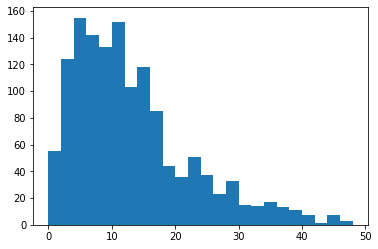

In [8]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,50,2))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [9]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [10]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [11]:


#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model300.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [12]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

2872 720
known words: 2872
unknown words: 720


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [13]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [14]:
inp = Input(shape=(maxlen,))

In [15]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1767 entries, 1 to 232
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  1767 non-null   object
 1   POS      1767 non-null   int32 
 2   NET      1767 non-null   int32 
 3   NEG      1767 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 48.3+ KB


In [17]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

Epoch 1/100

 ROC-AUC - epoch: 1 - score: 0.632148 

45/45 - 5s - loss: 0.6808 - accuracy: 0.3892 - val_loss: 0.6260 - val_accuracy: 0.3814
Epoch 2/100

 ROC-AUC - epoch: 2 - score: 0.657180 

45/45 - 4s - loss: 0.6440 - accuracy: 0.3928 - val_loss: 0.6087 - val_accuracy: 0.4802
Epoch 3/100

 ROC-AUC - epoch: 3 - score: 0.664479 

45/45 - 4s - loss: 0.6313 - accuracy: 0.4112 - val_loss: 0.6044 - val_accuracy: 0.5113
Epoch 4/100

 ROC-AUC - epoch: 4 - score: 0.673971 

45/45 - 5s - loss: 0.6342 - accuracy: 0.3956 - val_loss: 0.6057 - val_accuracy: 0.4774
Epoch 5/100

 ROC-AUC - epoch: 5 - score: 0.679132 

45/45 - 4s - loss: 0.6253 - accuracy: 0.4303 - val_loss: 0.6029 - val_accuracy: 0.4831
Epoch 6/100

 ROC-AUC - epoch: 6 - score: 0.683620 

45/45 - 4s - loss: 0.6280 - accuracy: 0.4126 - val_loss: 0.5959 - val_accuracy: 0.5282
Epoch 7/100

 ROC-AUC - epoch: 7 - score: 0.694011 

45/45 - 4s - loss: 0.6180 - accuracy: 0.4636 - val_loss: 0.5962 - val_accuracy: 0.5141
Epoch 8/100

 ROC-AU

Epoch 59/100

 ROC-AUC - epoch: 59 - score: 0.879644 

45/45 - 4s - loss: 0.2196 - accuracy: 0.8839 - val_loss: 0.4085 - val_accuracy: 0.7260
Epoch 60/100

 ROC-AUC - epoch: 60 - score: 0.874648 

45/45 - 4s - loss: 0.2030 - accuracy: 0.8995 - val_loss: 0.4217 - val_accuracy: 0.6949
Epoch 61/100

 ROC-AUC - epoch: 61 - score: 0.880148 

45/45 - 4s - loss: 0.1878 - accuracy: 0.9165 - val_loss: 0.4122 - val_accuracy: 0.7260
Epoch 62/100

 ROC-AUC - epoch: 62 - score: 0.880722 

45/45 - 4s - loss: 0.1882 - accuracy: 0.9030 - val_loss: 0.4065 - val_accuracy: 0.7316
Epoch 63/100

 ROC-AUC - epoch: 63 - score: 0.881221 

45/45 - 4s - loss: 0.1931 - accuracy: 0.9038 - val_loss: 0.4159 - val_accuracy: 0.7345
Epoch 64/100

 ROC-AUC - epoch: 64 - score: 0.883381 

45/45 - 4s - loss: 0.1704 - accuracy: 0.9137 - val_loss: 0.4388 - val_accuracy: 0.7373
Epoch 65/100

 ROC-AUC - epoch: 65 - score: 0.885247 

45/45 - 4s - loss: 0.1688 - accuracy: 0.9222 - val_loss: 0.4281 - val_accuracy: 0.7232
Epoch 

In [18]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           1077900   
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [19]:
from keras.models import load_model
c = model.predict(X_te)
c

array([[9.9981666e-01, 2.8821826e-04, 2.4598837e-04],
       [3.6552548e-04, 9.9663299e-01, 3.4399331e-03],
       [1.9029081e-03, 9.8088408e-01, 1.8024206e-02],
       ...,
       [5.8150291e-04, 5.5159330e-03, 9.9521673e-01],
       [9.9995196e-01, 2.3822198e-05, 7.1743131e-04],
       [3.9451724e-01, 7.2112715e-01, 1.1796951e-03]], dtype=float32)

In [20]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 19ms/step - loss: 0.5048 - accuracy: 0.7712
Test accuracy: 0.7711864113807678


In [21]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.897523133153003

In [22]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

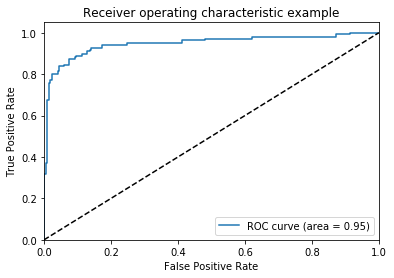

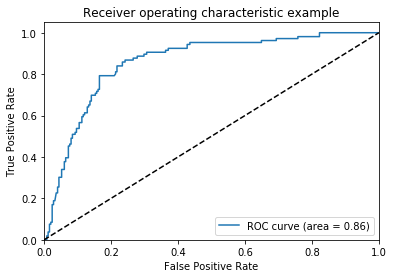

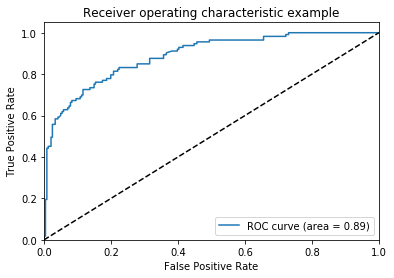

In [23]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
y_pred

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 1., 0.]], dtype=float32)

In [25]:
roc_auc_score(y_te, y_pred)

0.8303496371896445

In [26]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[198  21]
  [ 15 120]]

 [[195  53]
  [ 20  86]]

 [[198  43]
  [ 26  87]]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       135
           1       0.62      0.81      0.70       106
           2       0.67      0.77      0.72       113

   micro avg       0.71      0.83      0.77       354
   macro avg       0.71      0.82      0.76       354
weighted avg       0.72      0.83      0.77       354
 samples avg       0.76      0.83      0.78       354



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [28]:
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))

Hamming score: 0.7570621468926554


In [29]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.6864406779661016
Hamming loss: 0.16760828625235405


In [30]:
X_t[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   71,  432,   69,  199,  159,
          25,    9,  433,  662,    3,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         663,   22,   57,   53, 1415, 1416]])

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)) 

array([[120,  11,   4],
       [ 16,  80,  10],
       [  6,  36,  71]], dtype=int64)

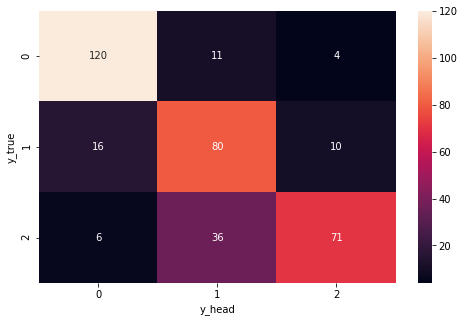

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()